In [1]:
# all imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import urllib.request as url
import json
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
import statsmodels.api as sm

gradient has 73 colors:


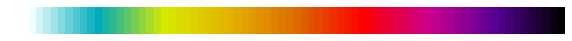

In [2]:
# this is (optional) to generate a custom gradient (interpolate n colors)
# https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python

#fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
def colorFader(c1,c2,mix=0): 
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

colors1 = ['#FFFFFF', '#51FFEA', '#00DC26', '#FFD000', '#EE003E', '#76006F']
colors = ['#EEFFFF','#00ABBB','#D8EA00','#E3B100','#DB6A00','#FF0000','#CB008F','#580096','#000000']

# interpolates add aditional colors in between colors of colors array
def interpolateColorGradient(colors, add):
    palette = [colors[0]]
    for c in range(len(colors)-1):
        for x in range(1,int(add+1)+1):
            palette += [colorFader(colors[c],colors[c+1],x/(add+1))]
    return palette

palette = []
palette = interpolateColorGradient(colors, 8)
print("gradient has", len(palette), "colors:")
fig, ax = plt.subplots(figsize=(10, 0.5))
for x in range(len(palette)):
    ax.axvline(x, color=palette[x], linewidth= 600 / len(palette)) 
plt.axis("off")
plt.show()
#print(palette)

In [3]:
# run this line to update the covid data file
url.urlretrieve('https://covid.ourworldindata.org/data/ecdc/full_data.csv', 'data/covid19.csv')

('data/covid19.csv', <http.client.HTTPMessage at 0x23805649e08>)

In [4]:
# setup data
world = gpd.read_file('data/110m_countries.shp')[['ADMIN', 'ADM0_A3', 'geometry']]
world = world.drop(world.index[159]) # remove Antarctica
world.columns = ['country', 'code', 'geometry'] # rename columns
world['country'] = world['country'].replace({'United States of America' : 'United States', 'Czechia' : 'Czech Republic', 'Republic of Serbia' : 'Serbia'})
cdata = pd.read_csv('data/covid19.csv').fillna(0)

In [5]:
# merge common data
date_start = min(cdata['date'])
date_end = max(cdata['date'])
dates = pd.date_range(date_start, date_end)

def json_data(selectedYear):
    yr = cdata[cdata['date'] == selectedYear]
    merged = world.merge(yr, left_on = 'country', right_on = 'location', how = 'left')
    merged.fillna('No data', inplace = True)
    merged.head
    merged_json = json.dumps(json.loads(merged.to_json()))
    return merged_json

In [6]:
# setup visualization
# DEFINE h for above which cases count a country is colored black!

h = 120000

cmap = LinearColorMapper(palette = palette, low = 0, high = h, nan_color = '#DCDCDC')
cbar = ColorBar(color_mapper = cmap, label_standoff = 9, width = 500, height = 20, border_line_color = None, location = (0,0), orientation = 'horizontal')

def plot_map(geosource, name):
    name = 'World Wide Corona Cases ' + name
    hover = HoverTool(tooltips = [ ('Region','@country'),('total cases', '@total_cases'), ('total deaths', '@total_deaths'), ('new cases', '@new_cases'), ('new deaths', '@new_deaths')])
    fig = figure(title = name, plot_height = 500, plot_width = 800, background_fill_color = '#88C4FE', tools = [hover, 'pan', 'wheel_zoom'], x_range=(-30, 110), y_range=(20, 80))
    fig.xgrid.grid_line_color = None
    fig.ygrid.grid_line_color = None
    fig.patches('xs', 'ys', source = geosource, fill_color = {'field' : 'total_cases', 'transform' : cmap}, line_color = 'black', line_width = 0.2, fill_alpha = 1)
    fig.add_layout(cbar, 'below')
    output_notebook() # jupyter notebook inline
    show(fig)

In [7]:
# show last n days
def show_recent(n):
    if (n == 'all'):
        n = len(dates)
    if (n > len(dates)): 
        print('No data for a time frame of', n, 'days!')
        return
    for i in range(n):
        date = str(dates[len(dates) - n + i])[:-9]
        src = GeoJSONDataSource(geojson = json_data(date))
        plot_map(src, date)

---

In [8]:
show_recent(3)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

---

In [9]:
def plot_last_days(n, region, window = 2):
    print(region + ':')
    data = cdata[cdata['location'] == region]
    data = data.reset_index()

    fig, (axcn, axdn, axct, axdt) = plt.subplots(1, 4, figsize = (9,2))
    
    create_subplot(axcn, data['new_cases'], n, 'new cases', window)
    create_subplot(axdn, data['new_deaths'], n, 'new deaths', window)
    create_subplot(axct, data['total_cases'], n, 'total cases', window)
    create_subplot(axdt, data['total_deaths'], n, 'total deaths', window)
    
    fig.subplots_adjust(right = 1.5)
    
    plt.show()
    
def create_subplot(ax, data, n, title, window):
    x = range(n+window)
    y, p = predict(data, n, window)
    ax.set_title(title)
    ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel('last ' + str(len(x)-window) + ' days + ' + str(window) + ' predicted')
    ax.set_ylim([0,max(y + p)])
    ax.plot(x,y)
    ax.plot(x,p)
    
def predict(data, n, window):
    model = sm.tsa.statespace.SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(method='powell',disp=0)
    y = [int(d) for d in data][-n:] + [np.nan]*window
    p = [np.nan]*(n-1) + y[-window-1:-window] + [int(x) for x in results.forecast(window)]
    print(p[-window:])
    return y, p

Germany:
[7248, 9533, 12878]
[60, 63, 61]
[55958, 66066, 80061]
[413, 525, 668]


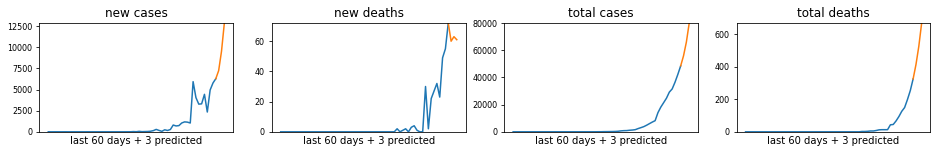

Italy:
[6057, 6122, 6195]
[908, 908, 1078]
[93133, 100273, 107702]
[10079, 11056, 12189]


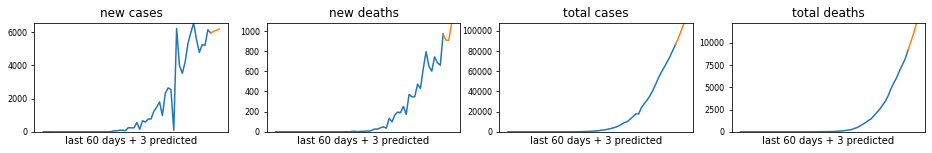

France:
[4774, 4209, 5115]
[334, 329, 217]
[37667, 42721, 48540]
[2484, 3092, 3669]


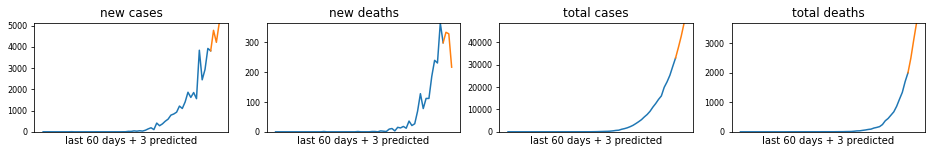

Spain:
[6692, 7893, 9449]
[654, 781, 715]
[73003, 83475, 95540]
[5863, 6993, 8370]


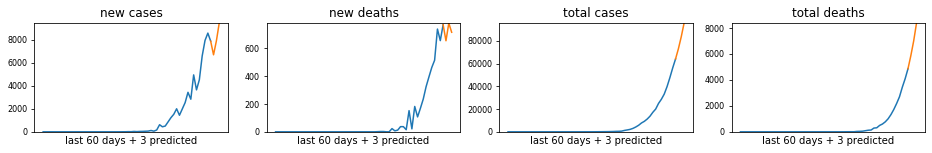

United Kingdom:
[3571, 4530, 5730]
[210, 81, 411]
[17519, 21280, 25973]
[976, 1091, 1490]


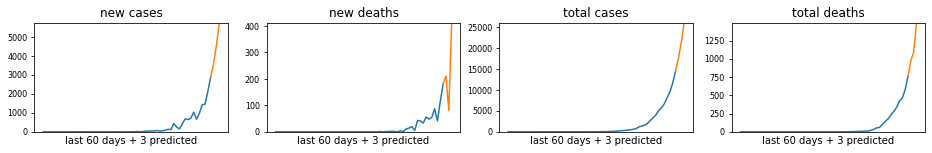

China:
[92, 78, 65]
[2, 3, 0]
[82325, 82424, 82511]
[3301, 3305, 3305]


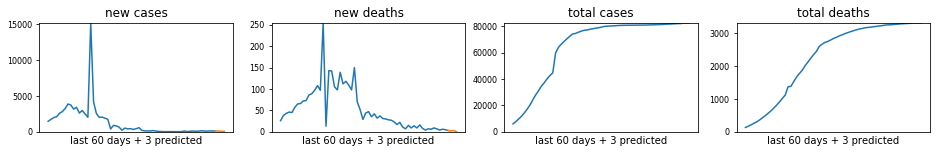

United States:
[18511, 34343, 54718]
[529, 688, 935]
[125653, 156739, 201650]
[2222, 2901, 3812]


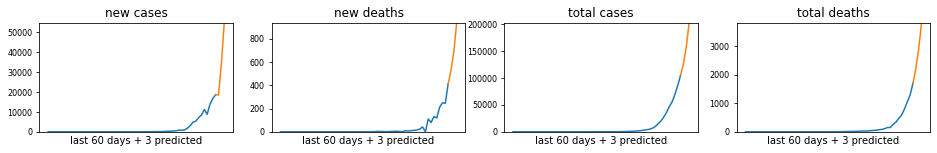

In [10]:
window = 3
n = 60
plot_last_days(n, 'Germany', window)
plot_last_days(n, 'Italy', window)
plot_last_days(n, 'France', window)
plot_last_days(n, 'Spain', window)
plot_last_days(n, 'United Kingdom', window)
plot_last_days(n, 'China', window)
plot_last_days(n, 'United States', window)